In [ ]:
import zipfile
import os


import cv2
import numpy as np
from glob import glob

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models


from sklearn.model_selection import train_test_split


In [ ]:
# convert tif file to png

image_folder = "/content/dataset/images"

tif_files = glob(os.path.join(image_folder, "*.tif"))

for tif_file in tif_files:
  img = Image.open(tif_file).convert('RGB')

  png_file = tif_file.replace(".tif", ".png")

  img.save(png_file)
  os.remove(tif_file)

print(f"converted {len(tif_file)} .tif files to .png")



converted 39 .tif files to .png


In [ ]:
# convert gif file to png

image_folder = "/content/dataset/masks"

gif_files = glob(os.path.join(image_folder, "*.gif"))

for gif_file in gif_files:
  img = Image.open(gif_file).convert('RGB')

  png_file = gif_file.replace(".gif", ".png")

  img.save(png_file)
  os.remove(gif_file)

print(f"converted {len(gif_file)} .gif files to .png")



converted 43 .gif files to .png


In [ ]:

os.listdir("/content/dataset/images")[:5]
os.listdir("/content/dataset/masks")[:5]

['30_training_mask.png',
 '22_training_mask.png',
 '26_training_mask.png',
 '23_training_mask.png',
 '36_training_mask.png']

Image shape (584, 565, 3)
Mask shape (584, 565)


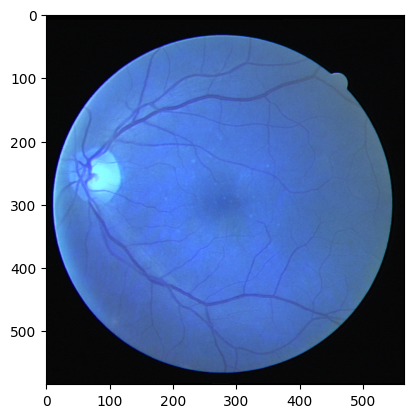

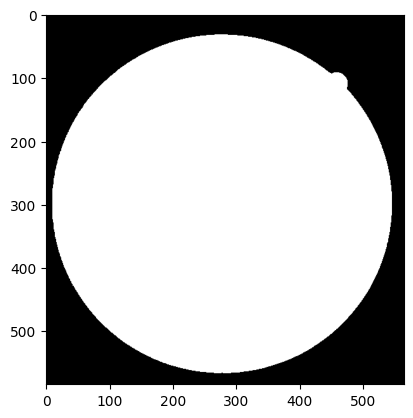

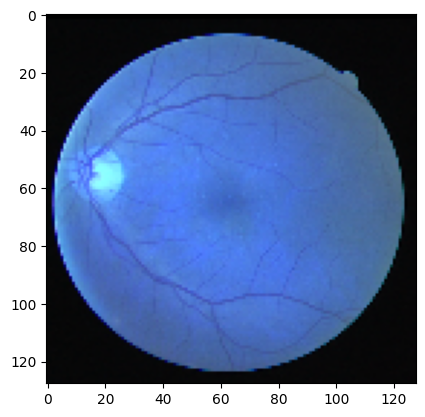

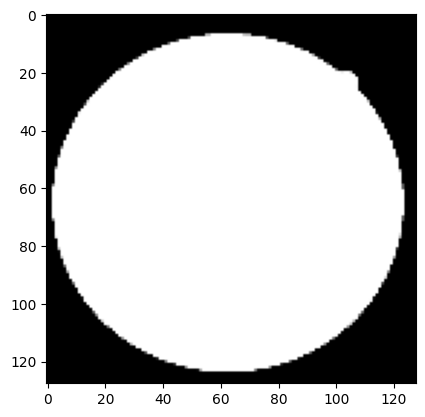

In [ ]:
image_paths = sorted(glob("/content/dataset/images/*.png"))
mask_paths = sorted(glob("/content/dataset/masks/*.png"))

image = cv2.imread(image_paths[0])
mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)

print("Image shape", image.shape)
print("Mask shape", mask.shape)

plt.imshow(image)
plt.show()

plt.imshow(mask, cmap="gray")
plt.show()

new_img = cv2.resize(image, (128, 128))
new_mask = cv2.resize(mask, (128, 128))

plt.imshow(new_img)
plt.show()

plt.imshow(new_mask, cmap="gray")
plt.show()

In [ ]:
img_height = 128
img_width = 128
batch_size = 16

def load_data(image_paths, mask_paths):

  images = []
  masks = []
  for i in range(len(image_paths)):

    image = cv2.imread(image_paths[i])
    image = cv2.resize(image, (img_width, img_height))
    image = image / 255.0
    images.append(image)

  for i in range(len(mask_paths)):

    mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_width, img_height))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    masks.append(mask)




  return np.array(images),np.array(masks)
x,y = load_data(image_paths, mask_paths)

print("Images shape", x.shape)
print("Masks shape", y.shape)

Images shape (20, 128, 128, 3)
Masks shape (20, 128, 128, 1)


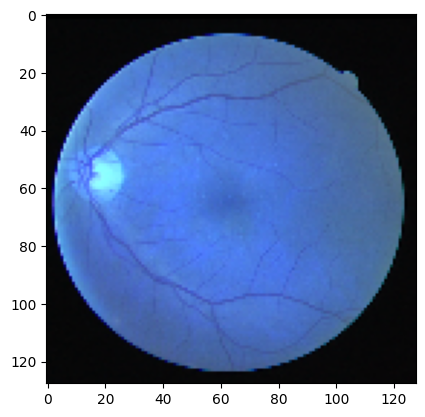

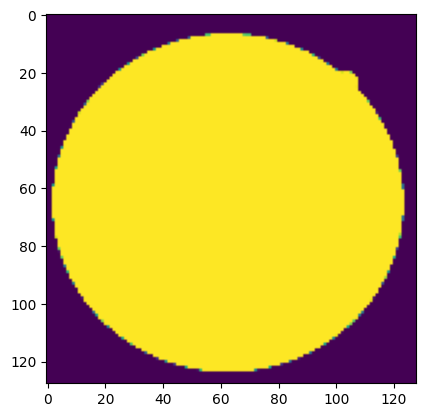

In [ ]:
plt.imshow(x[0])
plt.show()
plt.imshow(y[0])
plt.show()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.1, random_state=42)

In [ ]:
def unet_model(input_size=(128,128,3)):

  inputs = tf.keras.Input(input_size)

  # Encoder
  c1 = layers.Conv2D(64,3,activation='relu', padding='same')(inputs)
  c1 = layers.Conv2D(64,3,activation='relu', padding='same')(c1)
  p1 = layers.MaxPooling2D((2,2))(c1)

  c2 = layers.Conv2D(128,3,activation='relu', padding='same')(p1)
  c2 = layers.Conv2D(128,3,activation='relu', padding='same')(c2)
  p2 = layers.MaxPooling2D((2,2))(c2)

  c3 = layers.Conv2D(256,3,activation='relu', padding='same')(p2)
  c3 = layers.Conv2D(256,3,activation='relu', padding='same')(c3)
  p3 = layers.MaxPooling2D((2,2))(c3)

  c4 = layers.Conv2D(512,3,activation='relu', padding='same')(p3)
  c4 = layers.Conv2D(512,3,activation='relu', padding='same')(c4)
  p4 = layers.MaxPooling2D(pool_size=(2,2))(c4)

  # bottleneck

  c5 = layers.Conv2D(1024,3, activation='relu', padding='same')(p4)
  c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

  # Decoder

  u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2),padding='same')(c5)
  u6 = layers.concatenate([u6,c4])
  c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
  c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

  u7 = layers.Conv2DTranspose(256,(2,2), strides=(2,2), padding='same')(c6)
  u7 = layers.concatenate([u7,c3])
  c7 = layers.Conv2D(256,3,activation='relu', padding='same')(u7)
  c7 = layers.Conv2D(256,3, activation='relu', padding='same')(c7)

  u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
  u8 = layers.concatenate([u8,c2])
  c8 = layers.Conv2D(128,3, activation='relu', padding='same')(u8)
  c8 = layers.Conv2D(128,3,activation='relu', padding='same')(c8)


  u9 = layers.Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(c8)
  u9 = layers.concatenate([u9,c1], axis=3)
  c9 = layers.Conv2D(64,3,activation='relu', padding='same')(u9)
  c9 = layers.Conv2D(64,3,activation='relu', padding='same')(c9)

  outputs = layers.Conv2D(1,1, activation='sigmoid')(c9)

  model = models.Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
model = unet_model((128,128,3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    validation_data = (x_val,y_val),
    batch_size = batch_size,
    epochs = 20
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.7062 - loss: 0.6686 - val_accuracy: 0.6814 - val_loss: 0.4827
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.6853 - loss: 0.4793 - val_accuracy: 0.6814 - val_loss: 2.5424
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.6854 - loss: 2.1611 - val_accuracy: 0.6814 - val_loss: 0.3303
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.6852 - loss: 0.3410 - val_accuracy: 0.6930 - val_loss: 0.3456
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.7075 - loss: 0.3548 - val_accuracy: 0.9225 - val_loss: 0.3266
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9313 - loss: 0.3354 - val_accuracy: 0.9395 - val_loss: 0.2912
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.9468 - loss: 0.2982 - val_accuracy: 0.9572 - val_loss: 0.2435
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.9510 - loss: 0.2716 - val_accuracy: 0.9485 - val_loss: 0.2297
Epoch 9/20
2/2 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


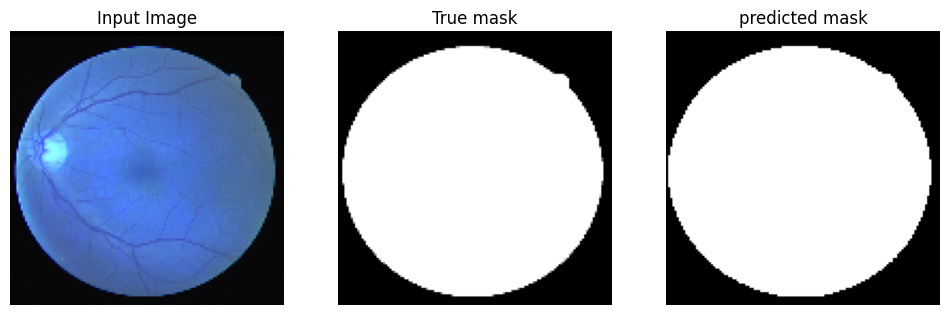

In [ ]:
def visualize_sample(idx):
  pred_mask = model.predict(x_val[idx:idx+1])[0,:,:,0]
  pred_mask = (pred_mask > 0.5).astype(np.uint8)

  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.title("Input Image")
  plt.imshow(x_val[idx])
  plt.axis('off')


  plt.subplot(1,3,2)
  plt.title("True mask")
  plt.imshow(y_val[idx].squeeze(), cmap='gray')
  plt.axis('off')


  plt.subplot(1,3,3)
  plt.title("predicted mask")
  plt.imshow(pred_mask, cmap='gray')
  plt.axis('off')

  plt.show()

visualize_sample(0)